"""
Avito, Russia’s largest classified advertisements website, is challenging you to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. 
"""

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [4]:
train_df = pd.read_csv("E:/pg/docs/BPB/data/avito/train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("E:/pg/docs/BPB/data/avito/test.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)

Train file rows and columns are :  (1503424, 18)
Test file rows and columns are :  (508438, 17)


In [5]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


"""
The train dataset description is as follows:

item_id - Ad id.
user_id - User id.
region - Ad region.
city - Ad city.
parent_category_name - Top level ad category as classified by Avito's ad model.
category_name - Fine grain ad category as classified by Avito's ad model.
param_1 - Optional parameter from Avito's ad model.
param_2 - Optional parameter from Avito's ad model.
param_3 - Optional parameter from Avito's ad model.
title - Ad title.
description - Ad description.
price - Ad price.
item_seq_number - Ad sequential number for user.
activation_date- Date ad was placed.
user_type - User type.
image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
image_top_1 - Avito's classification code for the image.
deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.
"""

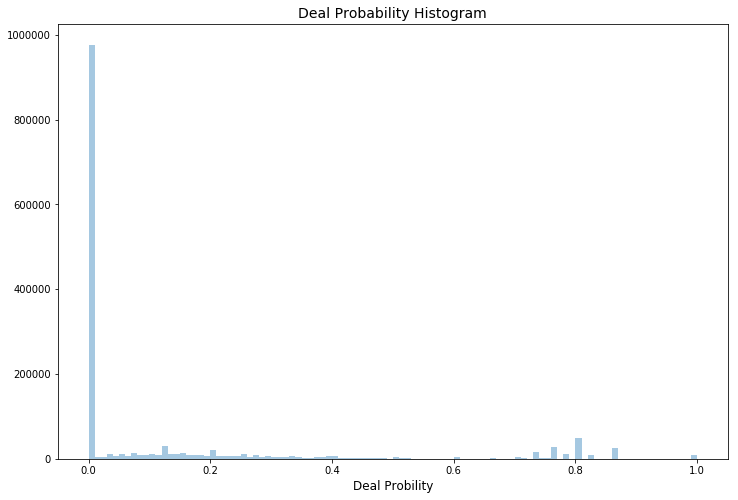

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

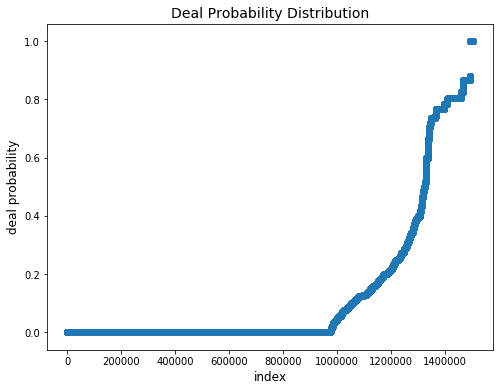

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

"""
So almost 100K Ads has 0 probaility (which means it did not sell anything) and few ads have a probability of 1. Rest of the deal probabilities have values in between.
"""

"""
Region wise distribution of Ads:
"""

In [9]:
from io import StringIO

temp_data = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, region_df, how="left", on="region")

In [10]:
temp_series = train_df['region_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

"""
The regions have percentage of ads between 1.71% to 9.41%. So the top regions are:

Krasnodar region - 9.41%
Sverdlovsk region - 6.28%
Rostov region - 5.99%
"""

C:\Users\prateek1.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



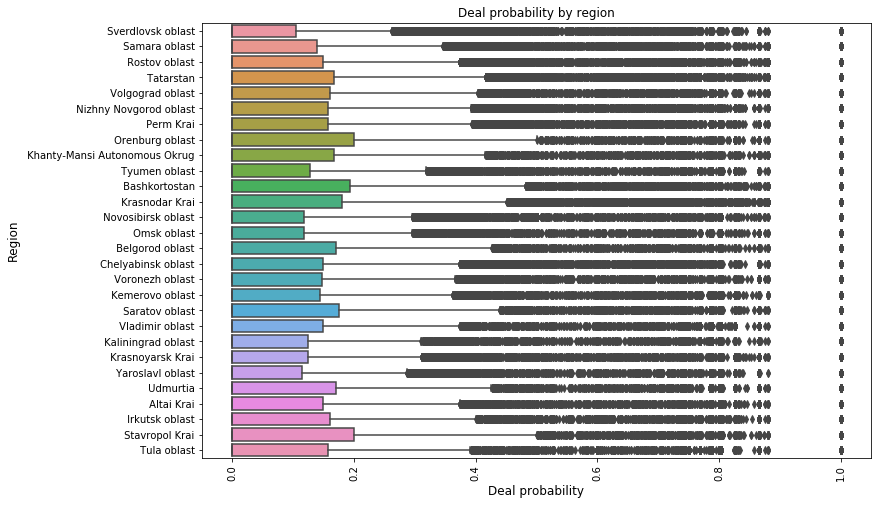

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region_en", x="deal_probability", data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

"""
City wise distribution of Ads:
"""

In [12]:
cnt_srs = train_df['city'].value_counts().head(20)
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='City distribution of Ads',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="CityAds")

"""
So the top cities where the ads are shown are

Krasnodar
Ekaterinburg
Novosibirsk
"""

"""
Parent Category Name:
"""

In [13]:
temp_data = StringIO("""
parent_category_name,parent_category_name_en
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")

In [14]:
temp_series = train_df['parent_category_name_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Parent Category distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="parentcategory")

"""
So 46.4% of the ads are for Personal belongings, 11.9% are for home and garden and 11.5% for consumer electronics.
"""

C:\Users\prateek1.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



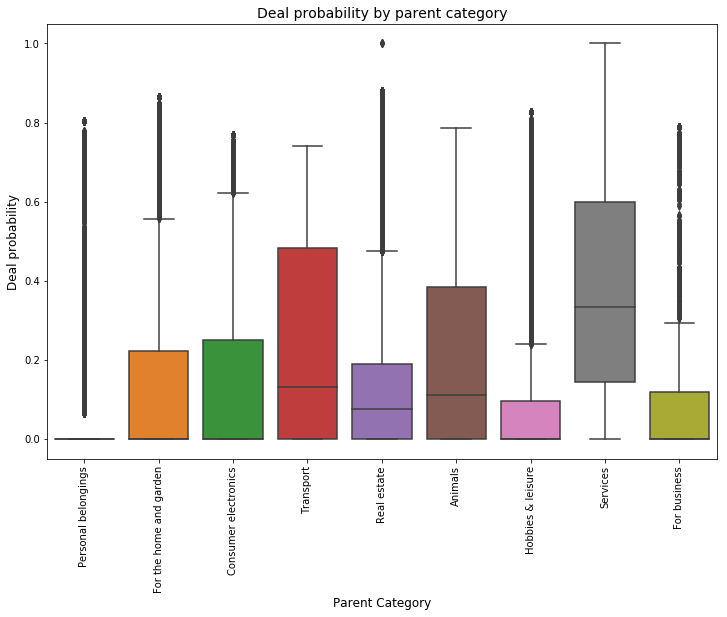

In [15]:
plt.figure(figsize=(12,8))
sns.boxplot(x="parent_category_name_en", y="deal_probability", data=train_df)
plt.ylabel('Deal probability', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Deal probability by parent category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

"""
Services category seems to have slightly higher deal probability compared to others.
"""

"""
Category of Ads:
"""

In [16]:
temp_data = StringIO("""
category_name,category_name_en
"Одежда, обувь, аксессуары","Clothing, shoes, accessories"
Детская одежда и обувь,Children's clothing and shoes
Товары для детей и игрушки,Children's products and toys
Квартиры,Apartments
Телефоны,Phones
Мебель и интерьер,Furniture and interior
Предложение услуг,Offer services
Автомобили,Cars
Ремонт и строительство,Repair and construction
Бытовая техника,Appliances
Товары для компьютера,Products for computer
"Дома, дачи, коттеджи","Houses, villas, cottages"
Красота и здоровье,Health and beauty
Аудио и видео,Audio and video
Спорт и отдых,Sports and recreation
Коллекционирование,Collecting
Оборудование для бизнеса,Equipment for business
Земельные участки,Land
Часы и украшения,Watches and jewelry
Книги и журналы,Books and magazines
Собаки,Dogs
"Игры, приставки и программы","Games, consoles and software"
Другие животные,Other animals
Велосипеды,Bikes
Ноутбуки,Laptops
Кошки,Cats
Грузовики и спецтехника,Trucks and buses
Посуда и товары для кухни,Tableware and goods for kitchen
Растения,Plants
Планшеты и электронные книги,Tablets and e-books
Товары для животных,Pet products
Комнаты,Room
Фототехника,Photo
Коммерческая недвижимость,Commercial property
Гаражи и машиноместа,Garages and Parking spaces
Музыкальные инструменты,Musical instruments
Оргтехника и расходники,Office equipment and consumables
Птицы,Birds
Продукты питания,Food
Мотоциклы и мототехника,Motorcycles and bikes
Настольные компьютеры,Desktop computers
Аквариум,Aquarium
Охота и рыбалка,Hunting and fishing
Билеты и путешествия,Tickets and travel
Водный транспорт,Water transport
Готовый бизнес,Ready business
Недвижимость за рубежом,Property abroad
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="category_name", how="left")

In [17]:
cnt_srs = train_df['category_name_en'].value_counts()
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='Category Name of Ads - Count',
    height=900
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="category name")

"""
So the top 3 categories are:

Clothes, shoes, accessories
Children's clothing and footwear
Goods for children and toys
"""

"""
User Type:
"""

In [18]:
temp_series = train_df['user_type'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='User Type distribution',
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

"""
So Private users constitute 72% of the data followed by company and shop.
"""

"""
Price:
"""

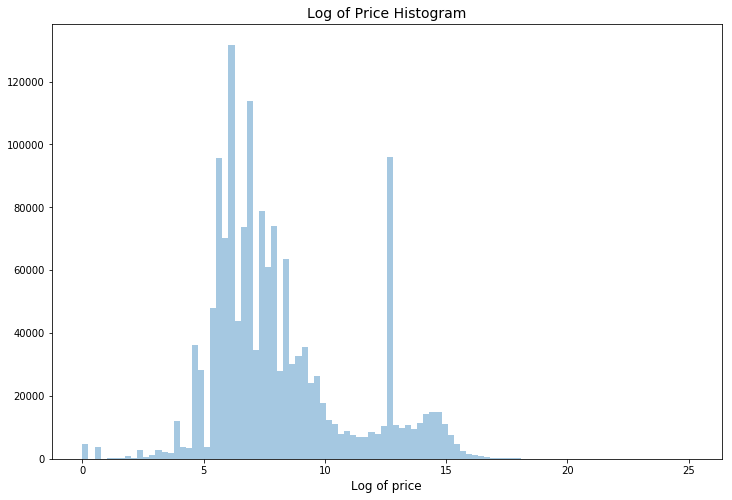

In [19]:
train_df["price_new"] = train_df["price"].values
train_df["price_new"].fillna(np.nanmean(train_df["price"].values), inplace=True)

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_df["price_new"].values), bins=100, kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

"""
Activation Date:
"""

In [20]:
cnt_srs = train_df['activation_date'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation Dates in Train'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

# Activation dates in test
cnt_srs = test_df['activation_date'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation Dates in Test'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

"""
So the dates are not different between train and test sets. So we need to be careful while doing our validation. May be time based validation is a good option.
We are given two weeks data for training (March 15 to March 28) and one week data for testing (April 12 to April 18, 2017).
There is a gap of two weeks in between training and testing data.
We can probably use weekday as a feature since all the days are present in both train and test sets.
"""

"""
User id:
"""

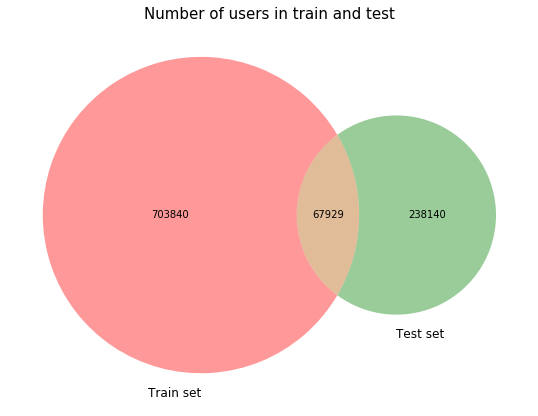

In [21]:
from matplotlib_venn import venn2

plt.figure(figsize=(10,7))
venn2([set(train_df.user_id.unique()), set(test_df.user_id.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of users in train and test", fontsize=15)
plt.show()

"""
So out of the 306K users in test, about 68K users are there in train and the rest are new.
"""

"""
Title:
"""

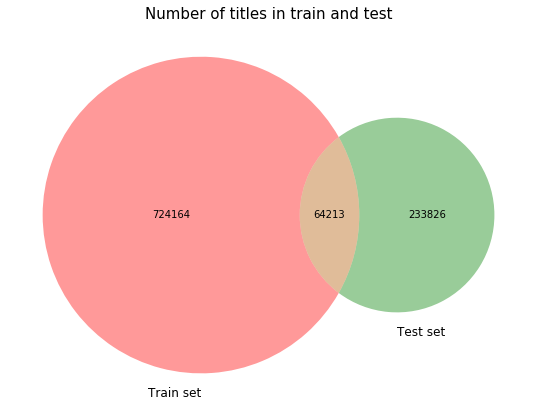

In [22]:
from matplotlib_venn import venn2

plt.figure(figsize=(10,7))
venn2([set(train_df.title.unique()), set(test_df.title.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of titles in train and test", fontsize=15)
plt.show()

In [23]:
# Now let us look at the number of words present in the title column.
train_df["title_nwords"] = train_df["title"].apply(lambda x: len(x.split()))
test_df["title_nwords"] = test_df["title"].apply(lambda x: len(x.split()))

cnt_srs = train_df['title_nwords'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in title column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords")   

"""
Now we will do the following:

Take the TF-IDF of the title column and this will be a sparse matrix with huge dimesnions.
Get the top SVD components fof this TF-IDF
Plot the distribution of SVD components with Deal probability to see if these variables help.
"""

In [24]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
full_tfidf = tfidf_vec.fit_transform(train_df['title'].values.tolist() + test_df['title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['title'].values.tolist())

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

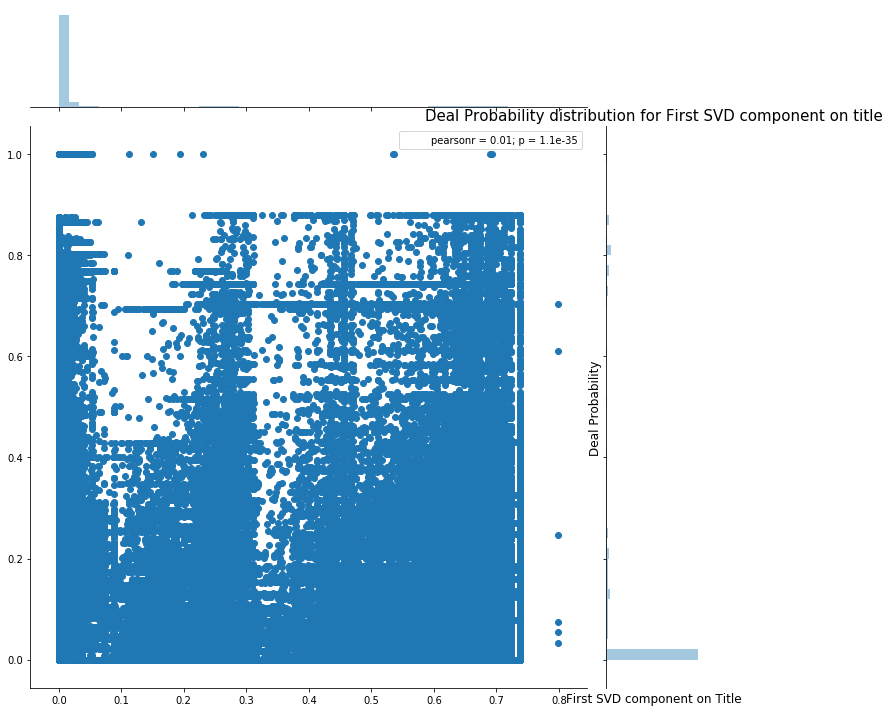

In [27]:
# 1st svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_1"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on title", fontsize=15)
plt.show()

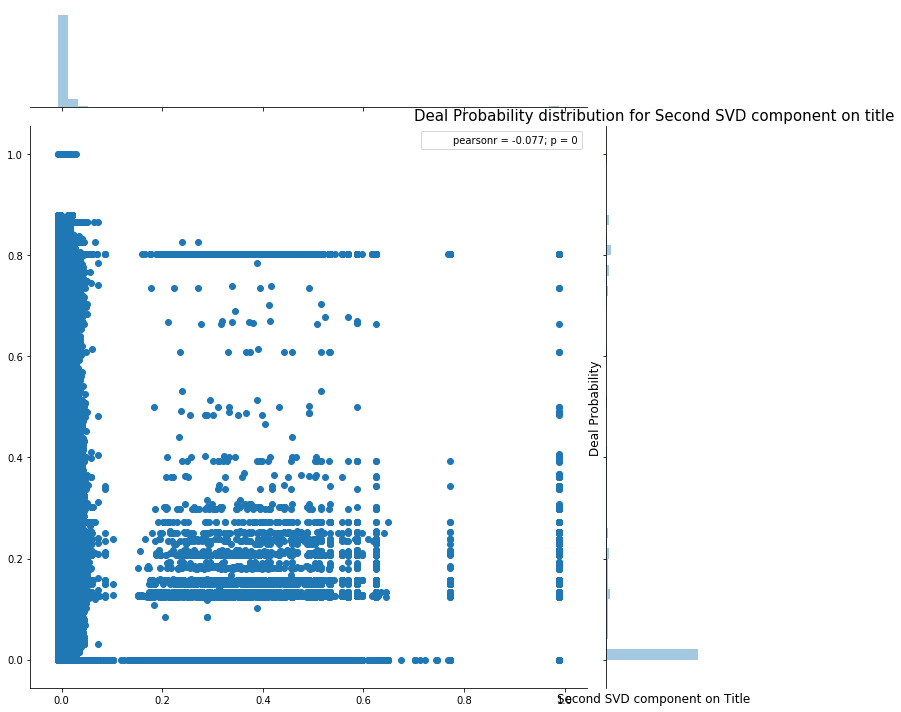

In [28]:
# 2nd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_2"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

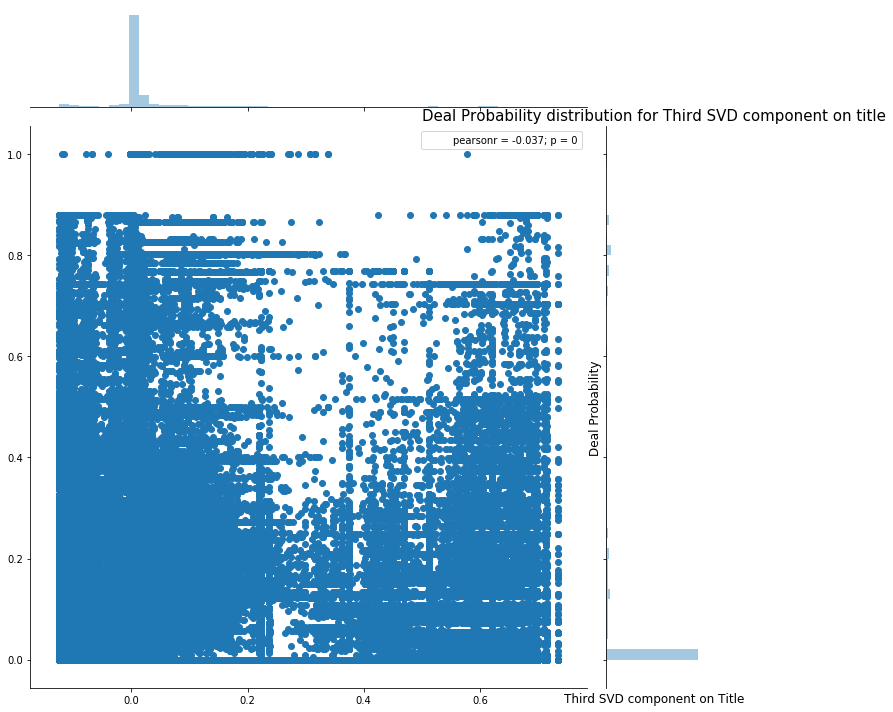

In [29]:
# 3rd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_3"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Third SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on title", fontsize=15)
plt.show()

"""
As we can see, the top SVD components capture quite an amount of variation in the data. So this might be helpful features in our modeling process.
"""

In [ ]:
"""
Description:
"""

In [30]:
## Filling missing values ##
train_df["description"].fillna("NA", inplace=True)
test_df["description"].fillna("NA", inplace=True)

train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))
test_df["desc_nwords"] = test_df["description"].apply(lambda x: len(x.split()))

cnt_srs = train_df['desc_nwords'].value_counts().head(100)

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in Description column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="desc_nwords")

"""
Description column has a huge right tail till about 700 words. I have cut the same till top 100 for better visualization.

Now let us create the first 3 SVD components for description column (just like title) and plot the same against deal probability.
"""

In [31]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_features=100000)
full_tfidf = tfidf_vec.fit_transform(train_df['description'].values.tolist() + test_df['description'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['description'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['description'].values.tolist())

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

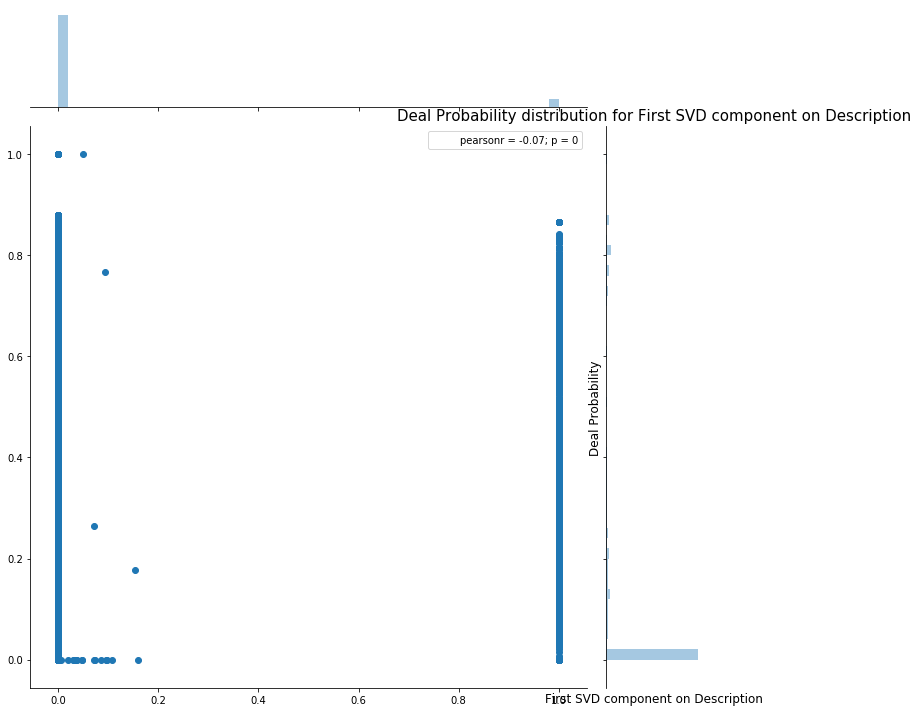

In [32]:
# 1st svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_1"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on Description", fontsize=15)
plt.show()

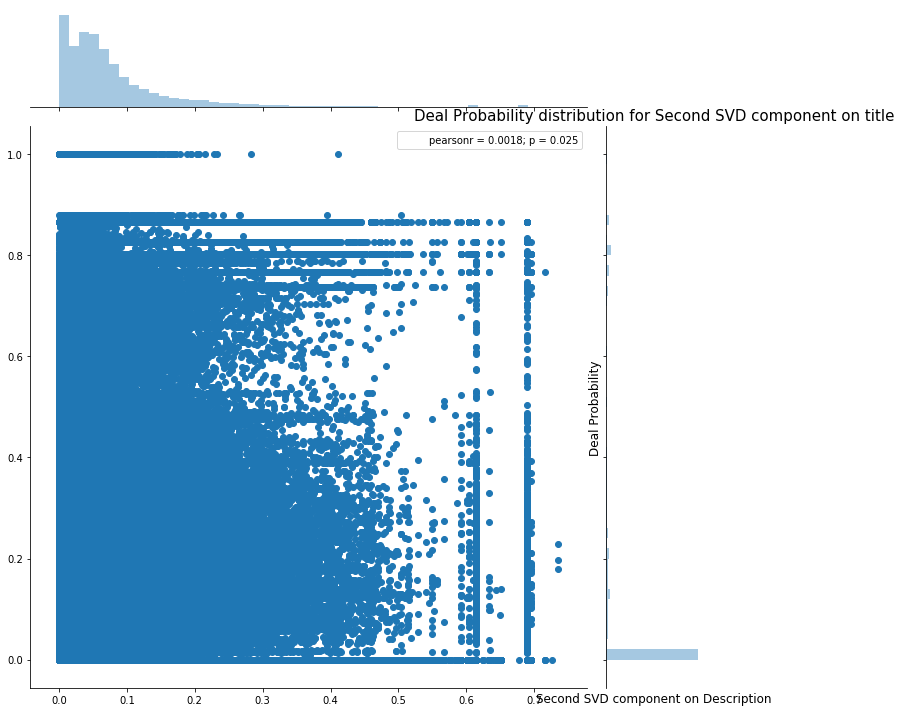

In [33]:
# 2nd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_2"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

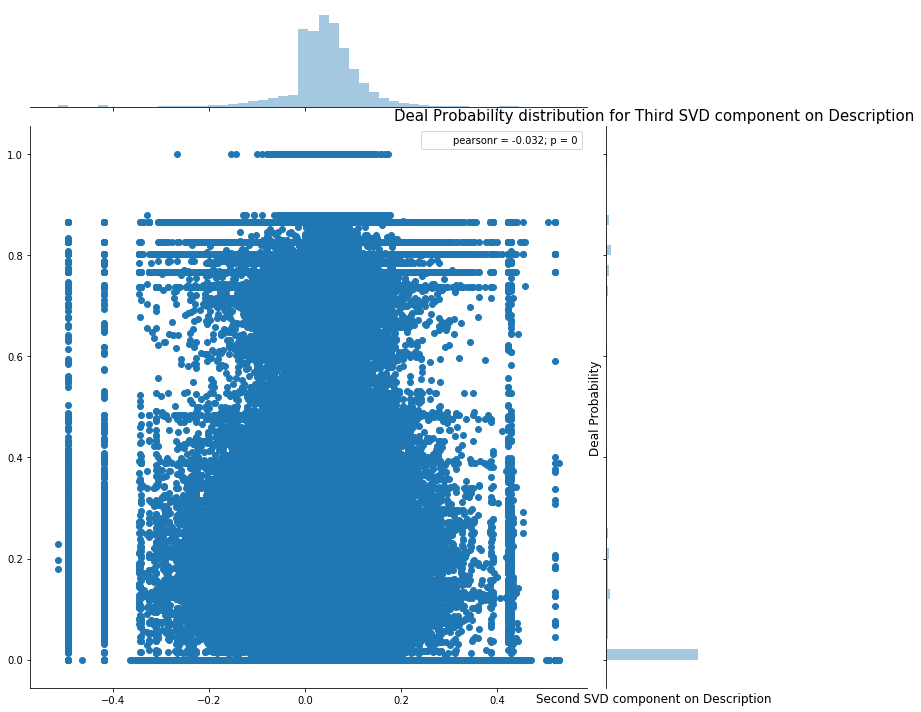

In [34]:
# 3rd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_3"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on Description", fontsize=15)
plt.show()

"""
Baseline Model:

Now let us build a baseline model using the given features and newly created features.

In the following block, we will do :

Create a new feature for week day
Label encode the cateforical variables
Drop the columns that are not needed in the model.
"""

In [35]:
# Target and ID variables #
train_y = train_df["deal_probability"].values
test_id = test_df["item_id"].values

# New variable on weekday #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
test_df["activation_weekday"] = test_df["activation_date"].dt.weekday

In [36]:
# Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image"]
train_X = train_df.drop(cols_to_drop + ["region_en", "parent_category_name_en", "category_name_en", "price_new", "deal_probability"], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

"""
Now let us create a custom function to build the LightGBM model.
"""

In [37]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [38]:
# Splitting the data for model training#
dev_X = train_X.iloc[:-200000,:]
val_X = train_X.iloc[-200000:,:]
dev_y = train_y[:-200000]
val_y = train_y[-200000:]
print(dev_X.shape, val_X.shape, test_X.shape)

(1303424, 20) (200000, 20) (508438, 20)


In [39]:
# Training the model #
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.235965
[40]	valid_0's rmse: 0.2329
[60]	valid_0's rmse: 0.231584
[80]	valid_0's rmse: 0.230648
[100]	valid_0's rmse: 0.230007
[120]	valid_0's rmse: 0.229545
[140]	valid_0's rmse: 0.229191
[160]	valid_0's rmse: 0.228837
[180]	valid_0's rmse: 0.228586
[200]	valid_0's rmse: 0.228323
[220]	valid_0's rmse: 0.22816
[240]	valid_0's rmse: 0.228025
[260]	valid_0's rmse: 0.227873
[280]	valid_0's rmse: 0.227764
[300]	valid_0's rmse: 0.227653
[320]	valid_0's rmse: 0.227551
[340]	valid_0's rmse: 0.227395
[360]	valid_0's rmse: 0.22729
[380]	valid_0's rmse: 0.227196
[400]	valid_0's rmse: 0.22712
[420]	valid_0's rmse: 0.227027
[440]	valid_0's rmse: 0.226961
[460]	valid_0's rmse: 0.226864
[480]	valid_0's rmse: 0.226802
[500]	valid_0's rmse: 0.226747
[520]	valid_0's rmse: 0.226681
[540]	valid_0's rmse: 0.226642
[560]	valid_0's rmse: 0.226577
[580]	valid_0's rmse: 0.226526
[600]	valid_0's rmse: 0.226443
[620]	valid_0's 

In [40]:
# Making a submission file #
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv("E:/pg/docs/BPB/data/avito/baseline_lgb.csv", index=False)

"""
Now let us look at the top features from the model.
"""

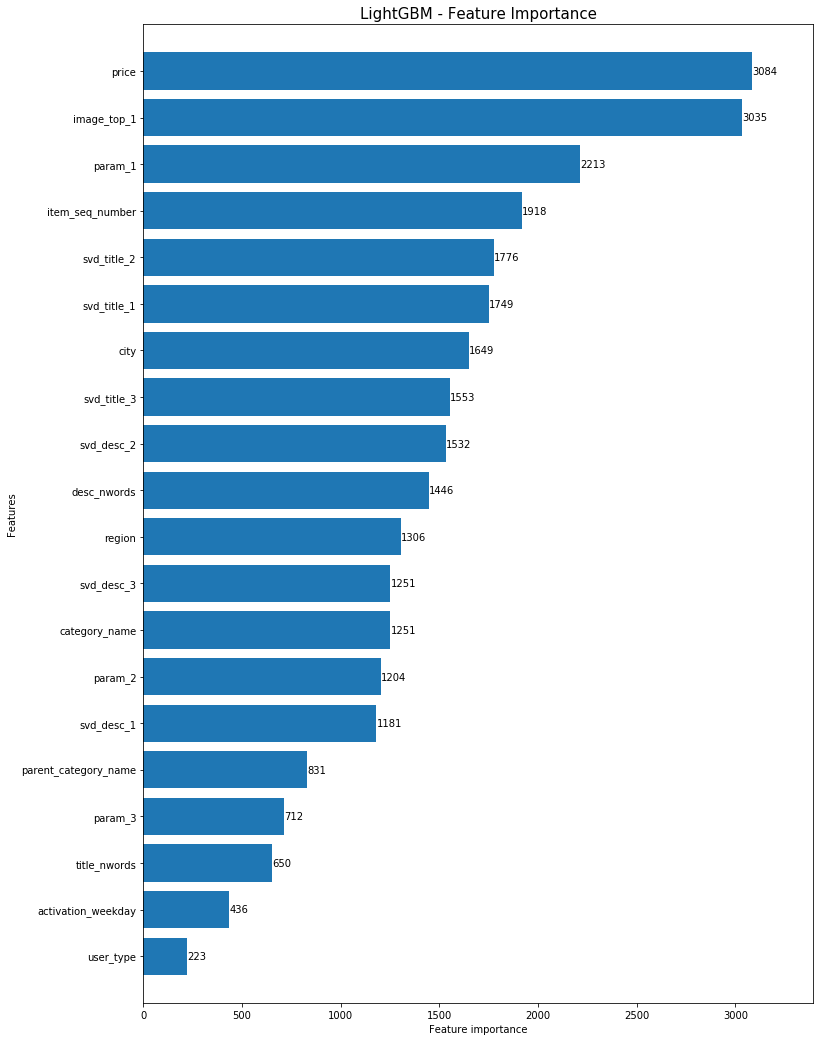

In [41]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()